In [434]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import sklearn.feature_extraction
from nltk.corpus import stopwords #For stopwords

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

#This will be doing most of the work
import networkx as nx

In [435]:
newsDF = pandas.read_csv('nu_simple.csv', encoding='utf-8')
len(newsDF)

1724

In [437]:
newsDF2 = pandas.read_csv('party_simple.csv', encoding='latin-1')
len(newsDF2)

25129

In [315]:
news_SMO = newsDF
#Tokenize sentences.
news_SMO['tokenized_sents'] = news_SMO['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
news_SMO['normalized_sents'] = news_SMO['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])
news_SMO.index = range(len(news_SMO) - 1, -1,-1) #Reindex to make things nice in the future

In [316]:
#Filter for articles from 2008-2009.
news_SMO_08 = news_SMO.loc[news_SMO['Year'] == 2008]
news_SMO_09 = news_SMO.loc[news_SMO['Year'] == 2009]
news_SMO_0809 = pandas.concat([news_SMO_08, news_SMO_09])

#Filter for articles from 2013-2014.
news_SMO_13 = news_SMO.loc[news_SMO['Year'] == 2013]
news_SMO_14 = news_SMO.loc[news_SMO['Year'] == 2014]
news_SMO_1314 = pandas.concat([news_SMO_13, news_SMO_14])

#Filter for articles from 2016-2017.
news_SMO_16 = news_SMO.loc[news_SMO['Year'] == 2016]
news_SMO_17 = news_SMO.loc[news_SMO['Year'] == 2017]
news_SMO_1617 = pandas.concat([news_SMO_16, news_SMO_17])

In [317]:
#Sample a random 100 articles from 2008-2009.
random_SMO_0809 = news_SMO_0809.sample(n=100)

#Sample a random 100 articles from 2013-2014.
random_SMO_1314 = news_SMO_1314.sample(n=100)

#Sample a random 100 articles from 2016-2017.
random_SMO_1617 = news_SMO_1617.sample(n=100)

<h2>Co-occurence Graph</h2>

Let's begin by looking at words that co-occur in the same sentences:

In [57]:
random_SMO_0809['tokenized_sents'] = random_SMO_0809['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
random_SMO_0809['normalized_sents'] = random_SMO_0809['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [58]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 news articles between 2008-2009.

In [127]:
g = wordCooccurrence(random_SMO_0809['normalized_sents'][:100].sum())

In [128]:
#Total number of vertices:
len(g.nodes)

3610

In [129]:
#Total number of edges:
len(g.edges)

96262

In [130]:
#A part of the adjacency matrix of cleaned word by press releases:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[ 0.,  0.,  0.,  0.,  0.],
        [ 0., 22.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]])

In [131]:
#We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [132]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [133]:
newsVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
newsVects_incidence = newsVectorizer.fit_transform(random_SMO_0809['Article'][:100])

In [134]:
newsVects_incidence.shape

(50, 3610)

In [135]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((newsVectorizer.get_feature_names()[i] for i in range(newsVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(newsVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, newsVectorizer.get_feature_names()[w], {'weight' : newsVects_incidence[d, w]}) for d, w in zip(*newsVects_incidence.nonzero())))

In [136]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 3660
Number of edges: 11209
Average degree:   6.1251


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding.

Let's plot the bipartite network with a quick spring layout:

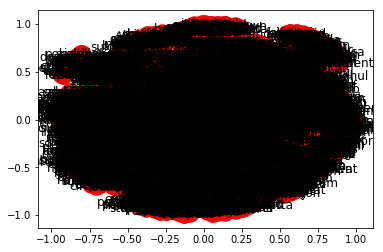

In [137]:
nx.draw_networkx(g_2mode)

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [138]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [139]:
gDoc = contractNetwork(g_2mode, 'doc')

In [140]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 50
Number of edges: 1225
Average degree:  49.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

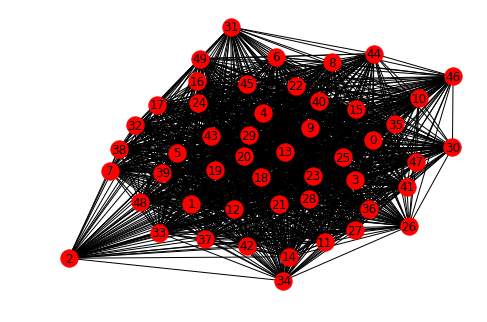

In [141]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying


Lets draw the graph with high and low weight edges distinguished:

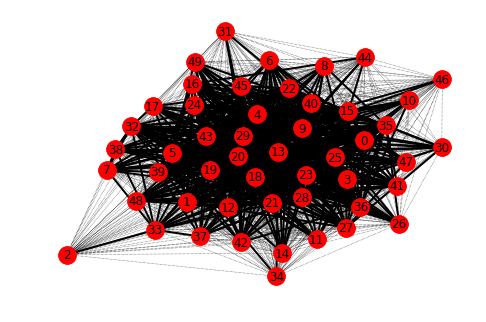

In [142]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [143]:
print(len(random_SMO_0809.iloc[2]['Article']),"words:","\n",random_SMO_0809.iloc[2]['Article'].strip().replace('  ', '\n'))

837 words: 
 JAKARTA: Islam Defenders Front (FPI) leader Rizieq Shihab is awaiting trial as the Jakarta Attorney General's Office (AGO) has handed his case file to the Central Jakarta District Court. "The file has been handed to the court," Wahyudi, an AGO prosecutor told reporters on Wednesday. Wahyudi came to the city police headquarters to hand over a file changing Rizieq's status from prosecutor's detention, to court detention. "He (Rizieq) will still stay here for the detention," he said, adding the court detention ran from 12 August to 12 September. FPI members lobbied the city police headquarters, demanding the release of Rizieq and Islam Troop Command leader Munarman. Rizieq will probably face trial at the Central Jakarta District Court, following the violent incident at the National Monument park (Monas) in Central Jakarta. -- JP


In [433]:
print(len(random_SMO_0809.iloc[46]['Article']),"words:","\n",random_SMO_0809.iloc[46]['Article'].strip().replace('  ', '\n'))

4723 words: 
 This week, Jakarta will host another conference on peace and conflict resolution, the third to be organized by Nahdlatul Ulama (NU) -- Indonesia's largest Muslim organization -- and one that will bring together Muslim scholars from various nations. That peace has become the focus of the conference -- and of many other conferences like it -- indicates the issue's importance to our time. In fact, a friend of mine, having returned from a trip overseas, recently said peace had become a precious commodity in the world, harder to achieve now than at any time in human history. For that reason, it is so galvanizing to see an organization like NU inviting scholars to share their experience with promoting peace the world over. Practically speaking, it is imperative in our increasingly interdependent world -- characterized by great cultural, ethnic, racial, national and religious diversity -- that we find ways to unite as a human family while honoring and respecting such diversity. 

Now let's turn it around and look at the word-to-word network by documents.

In [145]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 3610
Number of edges: 1046801
Average degree: 579.9452


First, let's reduce the number of words to a manageable size.

In [146]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.3723706798140238

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [147]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 10])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 86
Number of edges: 219
Average degree:   5.0930


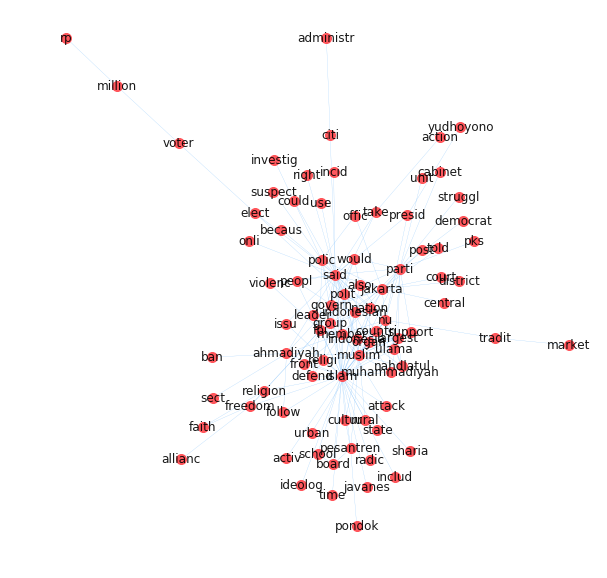

In [148]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [149]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 86
Number of edges: 219
Average degree:   5.0930


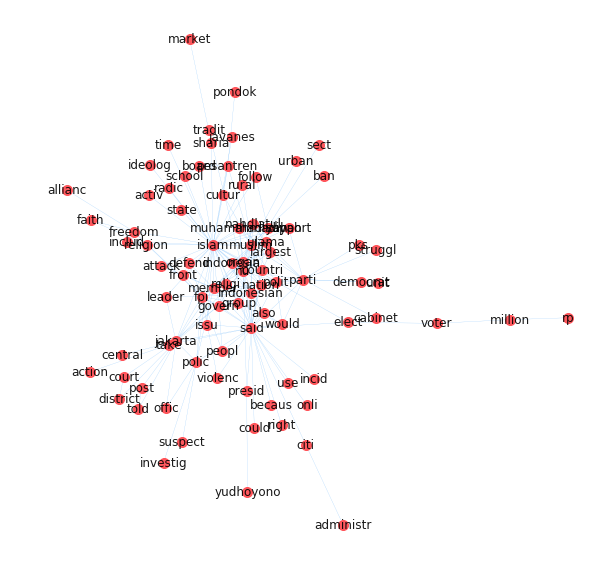

In [150]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [151]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 86
Number of edges: 219
Average degree:   5.0930


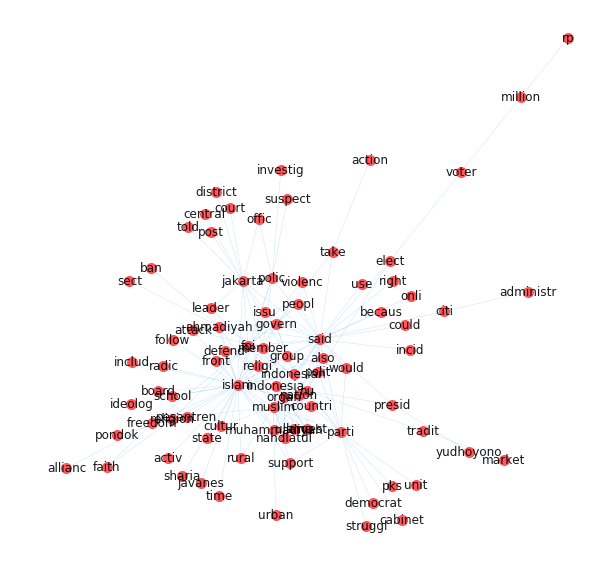

In [152]:

layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density.

Moreover, we can find cliques, or completely connected sets of nodes.

In [153]:
nx.clique.number_of_cliques(giant)['presid']

2

In [154]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

largest, muslim, nu, organ, ulama, nahdlatul


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'.

In [156]:
muslimNeighbors = giant.neighbors('muslim')
g_muslim = giant.subgraph(muslimNeighbors)
print(nx.info(g_muslim))

Name: 
Type: SubGraph
Number of nodes: 23
Number of edges: 90
Average degree:   7.8261


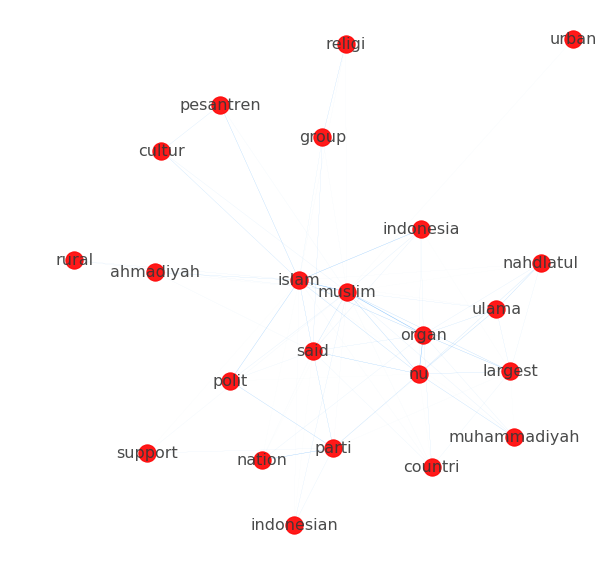

In [159]:
layout_amer = nx.spring_layout(g_muslim, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_muslim.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_muslim.edges(data = True)))
nx.draw(g_muslim, ax = ax, pos = layout_amer, labels = {n:n for n in g_muslim.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_muslim.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [160]:
muslimNeighbors = gWord.neighbors('muslim')
muslimNeighborsPlus1 = set(muslimNeighbors)
for n in muslimNeighbors:
    muslimNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [161]:
g_muslim2 = giant.subgraph(muslimNeighborsPlus1)
print(nx.info(g_muslim2))

Name: 
Type: SubGraph
Number of nodes: 85
Number of edges: 196
Average degree:   4.6118


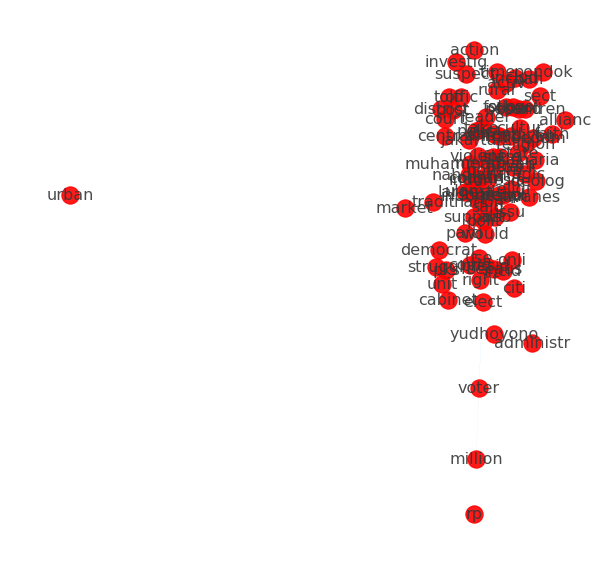

In [162]:
layout_muslim = nx.spring_layout(g_muslim2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_muslim = nx.eigenvector_centrality(g_muslim2)
maxC = max(centralities_muslim.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_muslim2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_muslim2.edges(data = True)))
nx.draw(g_muslim2, ax = ax, pos = layout_muslim, labels = {n:n for n in g_muslim2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_muslim2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

<h1>Network Statistics</h1>

In [164]:
dcentralities = nx.degree_centrality(giant)

In [165]:
dcentralities['presid']

0.03529411764705882

In [166]:
max(dcentralities.items(), key = lambda x : x[1])

('islam', 0.5294117647058824)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

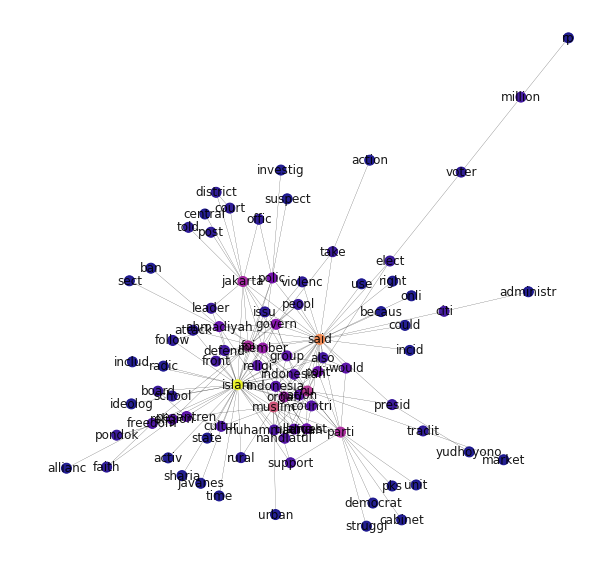

In [167]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

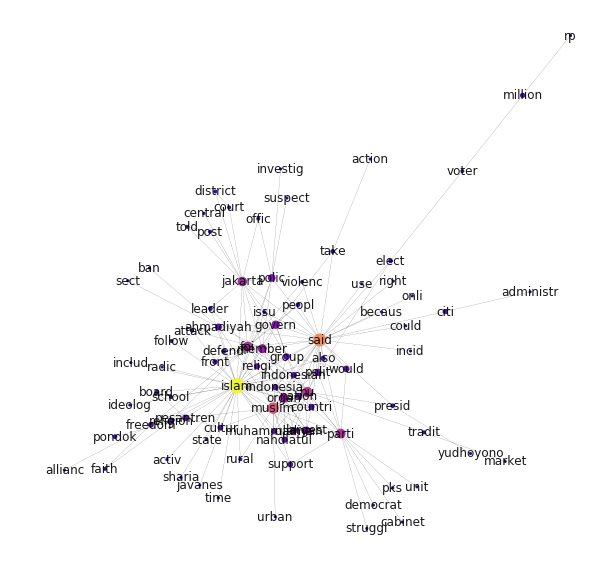

In [168]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

The distrubution of degree centrality is:

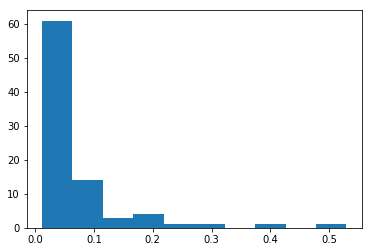

In [169]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [171]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('islam', 0.5294117647058824),
 ('said', 0.3764705882352941),
 ('muslim', 0.2823529411764706),
 ('nu', 0.22352941176470587),
 ('fpi', 0.2),
 ('parti', 0.2),
 ('jakarta', 0.18823529411764706),
 ('organ', 0.1764705882352941),
 ('member', 0.16470588235294117),
 ('govern', 0.1411764705882353)]

In [172]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('urban', 0.011764705882352941),
 ('right', 0.011764705882352941),
 ('sect', 0.011764705882352941),
 ('use', 0.011764705882352941),
 ('activ', 0.011764705882352941),
 ('could', 0.011764705882352941),
 ('rp', 0.011764705882352941),
 ('becaus', 0.011764705882352941),
 ('incid', 0.011764705882352941),
 ('unit', 0.011764705882352941)]

Consider another very different measure, which is betweenness centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high betweenness centrality nodes may not have the highest degree centrality.

In [173]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [175]:
centralities['muslim']

0.08417644680249722

In [176]:
max(centralities.items(), key = lambda x : x[1])

('islam', 0.4294174212031356)

We can color and size the nodes by betweenness centrality:

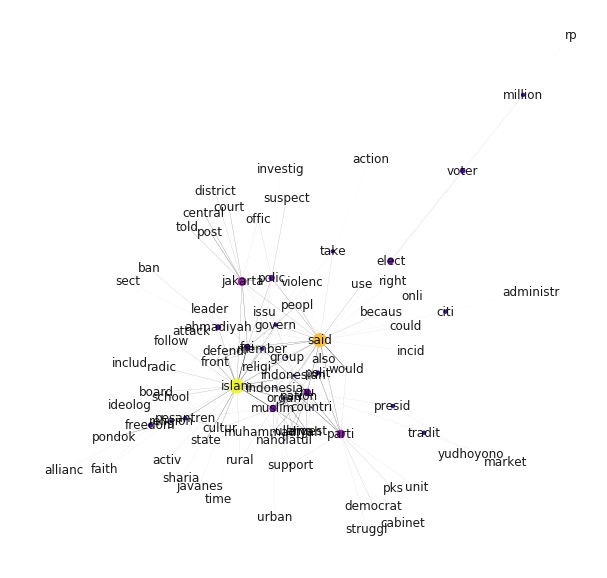

In [177]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

The distribution of betweenness centrality is:

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [180]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('islam', 0.5294117647058824),
 ('said', 0.3764705882352941),
 ('muslim', 0.2823529411764706),
 ('nu', 0.22352941176470587),
 ('fpi', 0.2),
 ('parti', 0.2),
 ('jakarta', 0.18823529411764706),
 ('organ', 0.1764705882352941),
 ('member', 0.16470588235294117),
 ('govern', 0.1411764705882353)]

Here it appears that "health"/"care"/"cost"/"medicar", "famili"/"children", and "bill" are key concepts that connect others in the broader network. This is interesting in that they seem to be domain-specific rather than linking words like "service" and "system".
What are words lower down?


We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [181]:
centralities = nx.closeness_centrality(giant)

fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

Top and bottom:

In [182]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('islam', 0.5985915492957746),
 ('said', 0.5862068965517241),
 ('muslim', 0.5059523809523809),
 ('nu', 0.5059523809523809),
 ('fpi', 0.4885057471264368),
 ('jakarta', 0.480225988700565),
 ('member', 0.480225988700565),
 ('polit', 0.4644808743169399),
 ('govern', 0.4644808743169399),
 ('organ', 0.4594594594594595)]

In [183]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('pondok', 0.28619528619528617),
 ('faith', 0.2823920265780731),
 ('voter', 0.2814569536423841),
 ('allianc', 0.2814569536423841),
 ('yudhoyono', 0.27960526315789475),
 ('action', 0.2750809061488673),
 ('administr', 0.2733118971061093),
 ('market', 0.25449101796407186),
 ('million', 0.22135416666666666),
 ('rp', 0.18162393162393162)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [184]:
centralities = nx.eigenvector_centrality(giant)

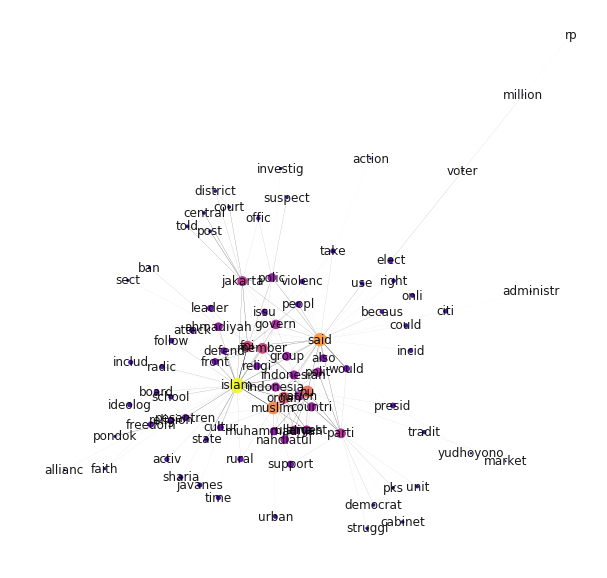

In [185]:
ig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma'))

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

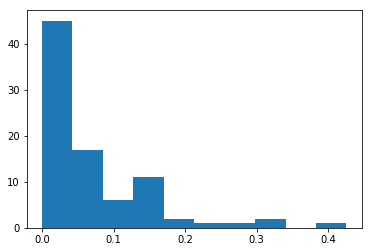

In [186]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [187]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('islam', 0.42559498027840953),
 ('said', 0.3233474632488137),
 ('muslim', 0.3010746508220293),
 ('nu', 0.26667150294924485),
 ('organ', 0.2434271237665801),
 ('fpi', 0.20873158572771383),
 ('member', 0.2038392539108057),
 ('jakarta', 0.17019207539211784),
 ('parti', 0.16571512908696173),
 ('nation', 0.15574340963266137)]

In [188]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('sect', 0.010208525875460372),
 ('pondok', 0.00701624625218973),
 ('allianc', 0.004939503965180185),
 ('yudhoyono', 0.004113515741557503),
 ('action', 0.0033318720758253634),
 ('voter', 0.003291631142750519),
 ('administr', 0.0024605253093557895),
 ('market', 0.0018591566365805808),
 ('million', 0.00030102268245368115),
 ('rp', 2.504762538257121e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [189]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [190]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 89
Average degree:   7.1200


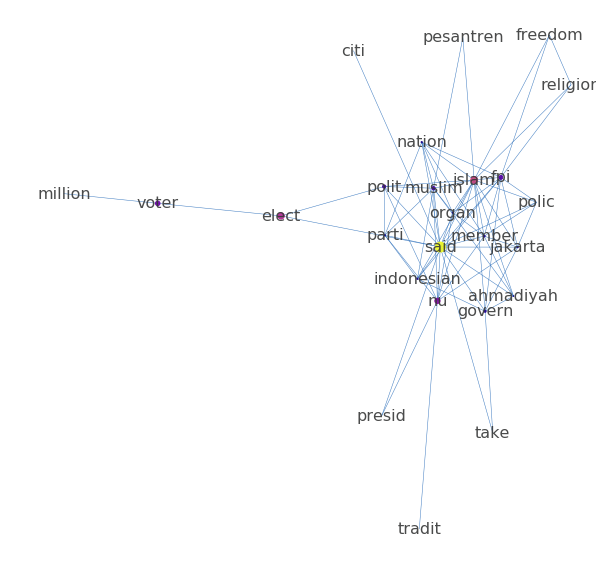

In [191]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [192]:
nx.density(giant)

0.059917920656634746

We can also calculate the average degree per node:

In [194]:
np.mean([v for w,v in nx.degree(giant)])

5.093023255813954

The diameter calculates the average distance between any two nodes in the network:

In [196]:
nx.diameter(giant)

7

<h1>POS based networks</h1>

Now let's look at links between specific parts of speech within a network. We will look at nouns co-occuring in sentences within articles on SMO between 2008-2009, 2013-2014, and 2016-2017.

In [234]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

<h3>Nouns in news articles</h3>

Let's look at nouns in articles on SMO between the 3 election cycles. Uncomment lines to select different election cycles.

In [461]:
#gNN = posCooccurrence(random_SMO_0809['normalized_sents'].sum(), 'NN')
#gNN = posCooccurrence(random_SMO_1314['normalized_sents'].sum(), 'NN')
gNN = posCooccurrence(random_SMO_1617['normalized_sents'].sum(), 'NN')

In [462]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 3166
Number of edges: 55500
Average degree:  35.0600


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [463]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 5]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2762
Number of edges: 54262
Average degree:  39.2918


And low weight edges:

In [464]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 5])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2762
Number of edges: 729
Average degree:   0.5279


In [465]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 10])
gNN.remove_nodes_from(list(nx.isolates(gNN))) #since we are changing the graph list() evaluates the isolates first
gNN = max(nx.connected_component_subgraphs(gNN), key=len) # keep just the giant connected component
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 69
Number of edges: 161
Average degree:   4.6667


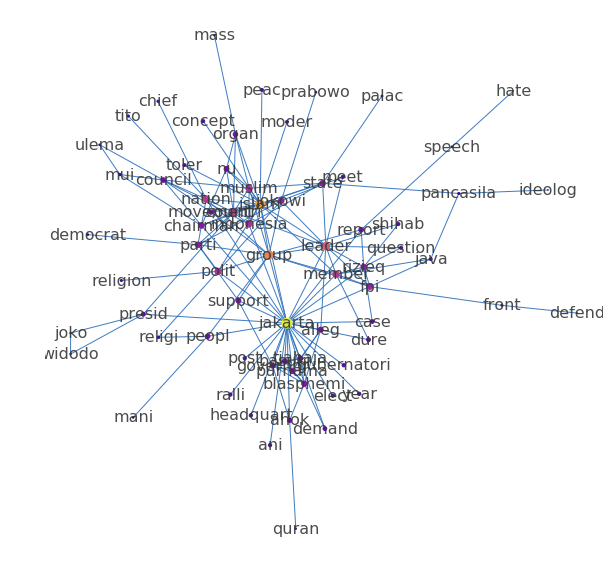

In [466]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

It is interesting that we are able to see political parties and several SMOs in this graph. More interestingly, we can see that FPI, a vigilante Islamist group is set apart from Muhammadiyah and NU. This means that **the media portrays them differently**. Furthermore, we can see that Muhammadiyah is closer to Nahdlatul Ulama (NU) than to FPI.

Lets create an "ego network" surrounding a single (important) word. Let's look at FPI, one of the social movement organizations that we have identified as a central actor in the social movement network (see Final Project notebook).

In [406]:
g_fpi = gNN.subgraph(['fpi'] + list(gNN.neighbors('fpi')))

What if we want to look at noun-verb pairs instead?

In [407]:
print(nx.info(g_fpi))

Name: 
Type: SubGraph
Number of nodes: 9
Number of edges: 20
Average degree:   4.4444


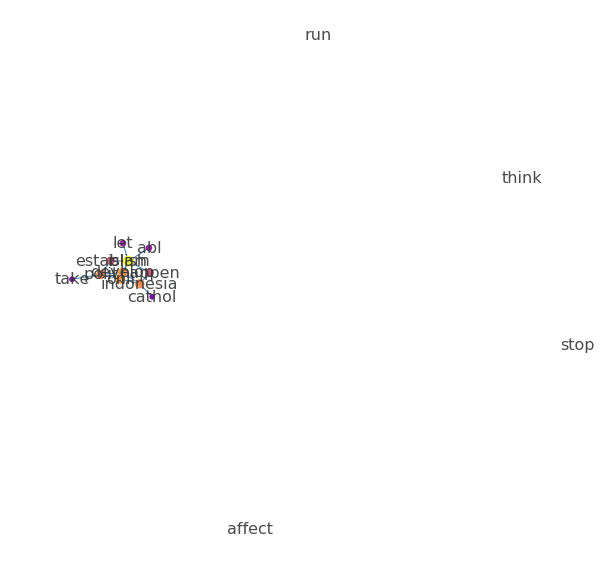

In [304]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

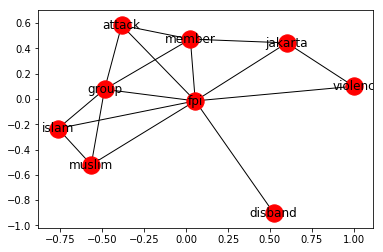

In [409]:
nx.draw_networkx(g_fpi)

In [412]:
fpiNeighbors = gNN.neighbors('fpi')
set(fpiNeighbors)

{'attack',
 'disband',
 'group',
 'islam',
 'jakarta',
 'member',
 'muslim',
 'violenc'}

In [413]:
fpiNeighbors = set(gNN.neighbors('fpi'))
fpiNeighborsPlus1 = set(fpiNeighbors)
for n in fpiNeighbors:
    fpiNeighborsPlus1 |= set(gNN.neighbors(n))

In [414]:
gNN_fpi = gNN.subgraph(fpiNeighborsPlus1)
print(nx.info(gNN_fpi))

Name: 
Type: SubGraph
Number of nodes: 45
Number of edges: 111
Average degree:   4.9333


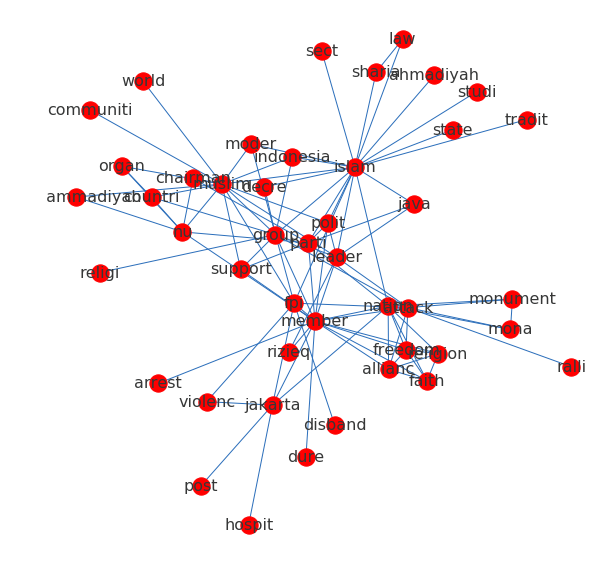

In [416]:
layout_fpi = nx.spring_layout(gNN_fpi, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNN_fpi, ax = ax, pos = layout_fpi, labels = {n: n for n in gNN_fpi.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

'Violence' and 'attack' are mentioned alongside FPI. This lets us infer that FPI is quite violent in its action. Furthermore, the mention of religion and faith close to attack might mean that their violence is motivated by disagreements in religious beliefs.

Let's compare FPI to Nahdlatul Ulama, an older social movement organization that is often denouncing FPI's violent actions. Can we see other organizations linked to NU?

In [417]:
g_nu = gNN.subgraph(['nu'] + list(gNN.neighbors('nu')))

In [418]:
print(nx.info(g_nu))

Name: 
Type: SubGraph
Number of nodes: 8
Number of edges: 17
Average degree:   4.2500


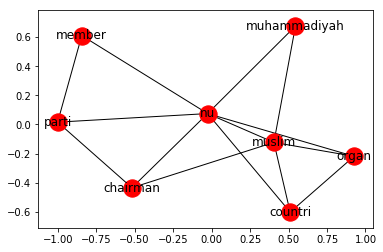

In [419]:
nx.draw_networkx(g_nu)

In [425]:
nuNeighbors = gNN.neighbors('nu')
set(nuNeighbors)

{'chairman', 'countri', 'member', 'muhammadiyah', 'muslim', 'organ', 'parti'}

In [430]:
nuNeighbors = set(gNN.neighbors('nu'))
nuNeighborsPlus1 = set(fpiNeighbors)
for n in nuNeighbors:
    nuNeighborsPlus1 |= set(gNN.neighbors(n))

In [431]:
gNN_nu = gNN.subgraph(nuNeighborsPlus1)
print(nx.info(gNN_nu))

Name: 
Type: SubGraph
Number of nodes: 42
Number of edges: 105
Average degree:   5.0000


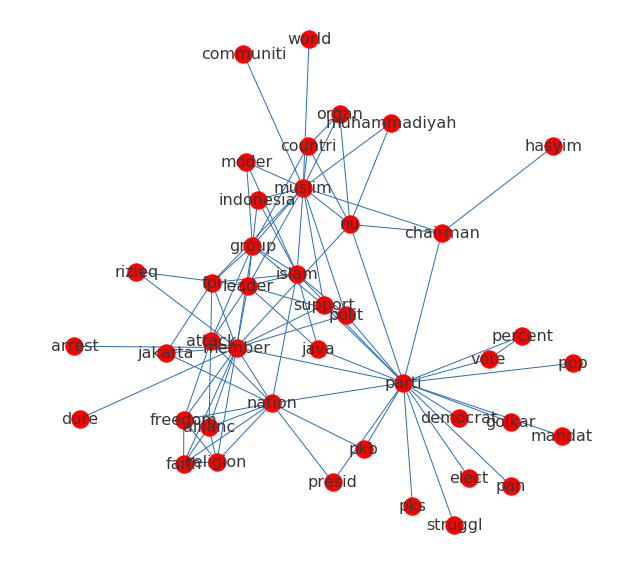

In [432]:
layout_nu = nx.spring_layout(gNN_nu, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNN_nu, ax = ax, pos = layout_nu, labels = {n: n for n in gNN_nu.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

In the tighter network, we can see that NU is closely related to Muhammadiyah. However, when we expanded the network we can see that FPI also appear in the network. This might be due to FPI's centrality to the whole network in general.

<h1>Semantic Networks: Noun-adjective network</h1>

In [343]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

<h2>2008-2009: SMO</h2>

In [332]:
gNJ = posCooccurrence(random_SMO_0809['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 4659
Number of edges: 112454
Average degree:  48.2739


In [333]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 251
Average degree:  20.0800


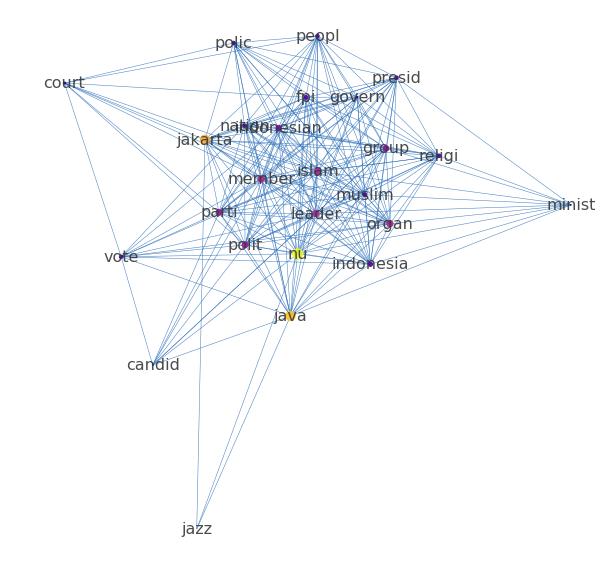

In [334]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

<h2>2013-2014: SMO</h2>

In [336]:
gNJ_2 = posCooccurrence(random_SMO_1314['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ_2))

Name: 
Type: Graph
Number of nodes: 4068
Number of edges: 95913
Average degree:  47.1549


In [337]:
gNJ_2_filtered200 = filterWords(gNJ_2, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_2_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 275
Average degree:  22.0000


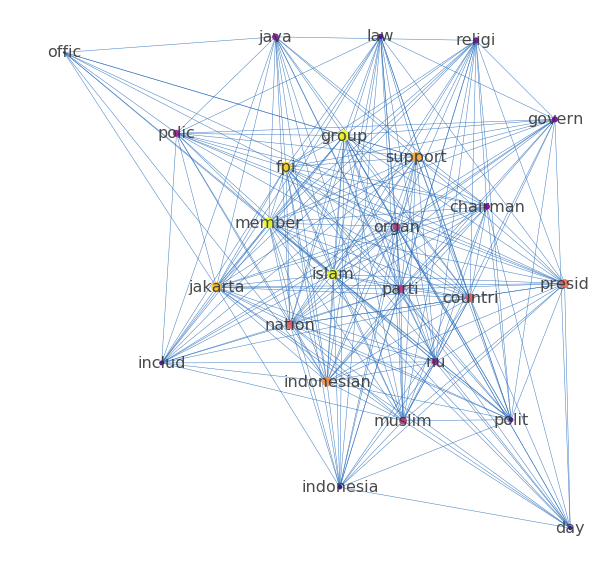

In [338]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_2_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_2_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_2_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_2_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_2_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_2_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

<h2>2016-2017: SMO</h2>

In [344]:
gNJ_3 = posCooccurrence(random_SMO_1617['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ_3))

Name: 
Type: Graph
Number of nodes: 3765
Number of edges: 93846
Average degree:  49.8518


In [345]:
gNJ_3_filtered200 = filterWords(gNJ_3, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_3_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 251
Average degree:  20.0800


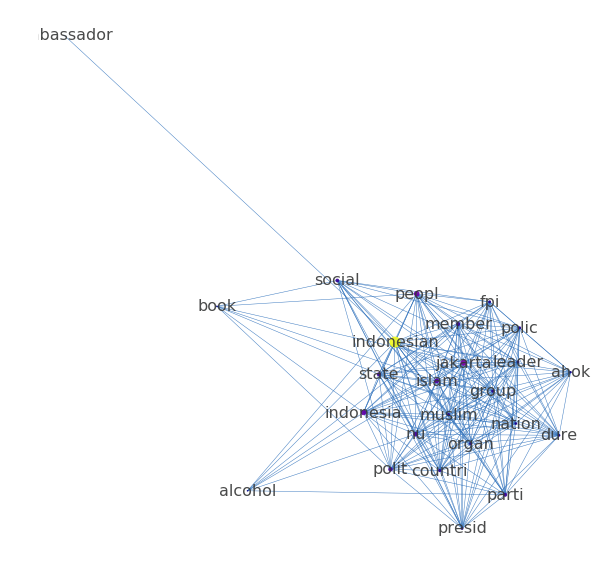

In [347]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_3_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_3_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_3_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_3_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_3_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_3_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

<h2>Exploring nouns for all data</h2>

What about all nouns over 2008-2018? Will we find a more pronounced difference between Islamic groups?

I am interested to see how the semantic network can cluster words into topics based on how each words relate to each other. Is it possible to distinguish different ideological approaches to political Islam related to different SMOs?

In [438]:
news_SMO = newsDF
#Tokenize sentences.
news_SMO['tokenized_sents'] = news_SMO['Article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
news_SMO['normalized_sents'] = news_SMO['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])
news_SMO.index = range(len(news_SMO) - 1, -1,-1) #Reindex to make things nice in the future

Let's look at 1000 articles.

In [439]:
gNN_4 = posCooccurrence(news_SMO['normalized_sents'][:1000].sum(), 'NN')
print(nx.info(gNJ_4))

Name: 
Type: Graph
Number of nodes: 13249
Number of edges: 682815
Average degree: 103.0742


In [459]:
gNN_4_filtered200 = filterWords(gNN_4, minWeight=5, filter_='betweenness', rule='number', value_of_rule=40)
print(nx.info(gNN_4_filtered200))

Total number of nodes(after filtering) in the graph is 40
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 636
Average degree:  31.8000


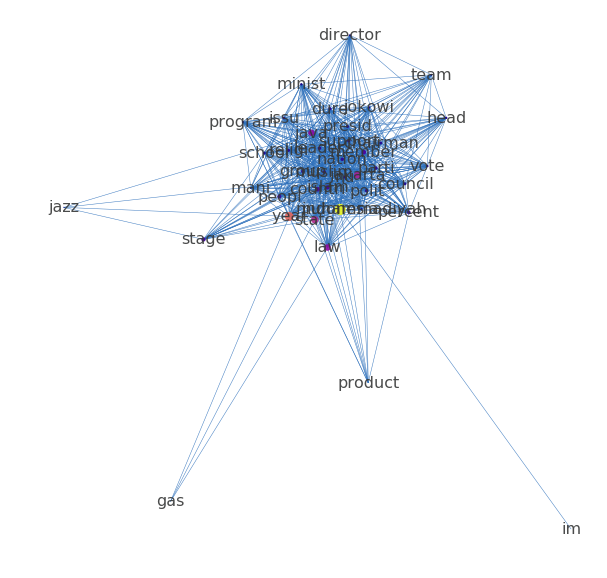

In [460]:
layout_NN_filtered200 = nx.spring_layout(gNN_4_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn200 = nx.betweenness_centrality(gNN_4_filtered200)
maxC = max(centralities_nn200.items(), key = lambda x : x[1])[1]
nx.draw(gNN_4_filtered200, ax = ax, pos = layout_NN_filtered200, labels = {n: n for n in gNN_4_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nn200[n] / maxC for n in gNN_4_filtered200.nodes],
        node_size = [centralities_nn200[n] / maxC * 100 for n in gNN_4_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )